In [2]:
# Lets import our libraries and use the Python interactive shell to display all results if needed throughout the program

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.model_selection import train_test_split
import os
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [3]:
# Lets load and explore the dataset using pandas

path = './steam-200k.csv'

df = pd.read_csv(path, header = None,
                 names = ['UserID', 'Game', 'Action', 'Hours', 'Not Needed'])
df.head()


,UserID,Game,Action,Hours,Not Needed
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [4]:
# Creating a new variable 'Hours Played' and code it as previously described.
df['Hours_Played'] = df['Hours'].astype('float32')

df.loc[(df['Action'] == 'purchase') & (df['Hours'] == 1.0), 'Hours_Played'] = 0

In [5]:
# Sort the df by User ID, games, and hours played
# Drop the duplicated records, and unnecessary columns

df.UserID = df.UserID.astype('int')
df = df.sort_values(['UserID', 'Game', 'Hours_Played'])

clean_df = df.drop_duplicates(['UserID', 'Game'], keep = 'last').drop(['Action', 'Hours', 'Not Needed'], axis = 1)

# every transaction is represented by only one record now
clean_df.head()

,UserID,Game,Hours_Played
65430,5250,Alien Swarm,4.9
65424,5250,Cities Skylines,144.0
65435,5250,Counter-Strike,0.0
65436,5250,Counter-Strike Source,0.0
65437,5250,Day of Defeat,0.0


In [6]:
# Let's see how many unique players and how many unique games there are

n_users = len(clean_df.UserID.unique())
n_games = len(clean_df.Game.unique())

print('There are {0} users and {1} games in the data'.format(n_users, n_games))

There are 12393 users and 5155 games in the data


In [7]:
# If we build a matrix of users x games, how many cells in the matrix will be filled?
sparsity = clean_df.shape[0] / float(n_users * n_games)
print('{:.2%} of the user-item matrix is filled'.format(sparsity))

0.20% of the user-item matrix is filled


In [8]:
# Create the dictionaries to convert user and games to idx and back
user2idx = {user: i for i, user in enumerate(clean_df.UserID.unique())}
idx2user = {i: user for user, i in user2idx.items()}

game2idx = {game: i for i, game in enumerate(clean_df.Game.unique())}
idx2game = {i: game for game, i in game2idx.items()}

In [9]:
# Convert the user and games to idx
user_idx = clean_df['UserID'].apply(lambda x: user2idx[x]).values
game_idx = clean_df['gameIdx'] = clean_df['Game'].apply(lambda x: game2idx[x]).values
hours = clean_df['Hours_Played'].values

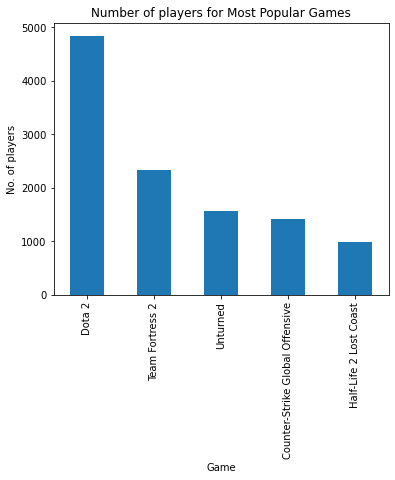

In [10]:
# We can plot the number of players for the most popular games

gb = df.groupby('Game')['UserID'].nunique().sort_values(ascending=False).head()
ax = gb.plot(kind='bar', title='Number of players for Most Popular Games', ylabel='No. of players',
         xlabel='Game', figsize=(6, 5))


In [11]:
# Create a matrix of users x games

zero_matrix = np.zeros(shape = (n_users, n_games)) # Create a zero matrix
user_game_pref = zero_matrix.copy()
user_game_pref[user_idx, game_idx] = 1 # Fill the matrix will preferences (bought)

user_game_interactions = zero_matrix.copy()

# Fill the confidence with (hours played)
# Added 1 to the hours played so that we have min. confidence for games bought but not played.
user_game_interactions[user_idx, game_idx] = hours + 1 

In [12]:
k = 5 

# Count the number of purchases for each user

purchase_counts = np.apply_along_axis(np.bincount, 1, user_game_pref.astype(int))
buyers_idx = np.where(purchase_counts[:, 1] >= 2 * k)[0] # find the users who purchase 2 * k games
print('{0} users bought {1} or more games'.format(len(buyers_idx), 2 * k))

2189 users bought 10 or more games


In [13]:
# Data Split - We'll 10% of the data for validation and 10% for testing.
test_frac = 0.2 
test_users_idx = np.random.choice(buyers_idx,
                                  size = int(np.ceil(len(buyers_idx) * test_frac)),
                                  replace = False)

In [14]:
val_users_idx = test_users_idx[:int(len(test_users_idx) / 2)]
test_users_idx = test_users_idx[int(len(test_users_idx) / 2):]

In [15]:
# A function used to mask the preferences data from training matrix
def data_process(dat, train, test, user_idx, k):
    for user in user_idx:
        purchases = np.where(dat[user, :] == 1)[0]
        mask = np.random.choice(purchases, size = k, replace = False)
        
        train[user, mask] = 0
        test[user, mask] = dat[user, mask]
    return train, test

In [16]:
train_matrix = user_game_pref.copy()
test_matrix = zero_matrix.copy()
val_matrix = zero_matrix.copy()

# Mask the train matrix and create the validation and test matrices
train_matrix, val_matrix = data_process(user_game_pref, train_matrix, val_matrix, val_users_idx, k)
train_matrix, test_matrix = data_process(user_game_pref, train_matrix, test_matrix, test_users_idx, k)

In [17]:
# let's take a look at what was actually accomplised
# You can see the test matrix preferences are masked in the train matrix
test_matrix[test_users_idx[0], test_matrix[test_users_idx[0], :].nonzero()[0]]

array([1., 1., 1., 1., 1.])

In [18]:
train_matrix[test_users_idx[0], test_matrix[test_users_idx[0], :].nonzero()[0]]

array([0., 0., 0., 0., 0.])

In [19]:
tf.reset_default_graph() # Create new graph

pref = tf.placeholder(tf.float32, (n_users, n_games))  # Here's the preference matrix
interactions = tf.placeholder(tf.float32, (n_users, n_games)) # Here's the hours played matrix
users_idx = tf.placeholder(tf.int32, (None))

In [20]:
n_features = 30 # Number of latent features to be extracted

# The X matrix represents the user latent preferences with a shape of user x latent features
X = tf.Variable(tf.truncated_normal([n_users, n_features], mean = 0, stddev = 0.05))

# The Y matrix represents the game latent features with a shape of game x latent features
Y = tf.Variable(tf.truncated_normal([n_games, n_features], mean = 0, stddev = 0.05))

# Here's the initilization of the confidence parameter
conf_alpha = tf.Variable(tf.random_uniform([1], 0, 1))

In [21]:
# Initialize a user bias vector
user_bias = tf.Variable(tf.truncated_normal([n_users, 1], stddev = 0.2))

# Concatenate the vector to the user matrix
# Due to how matrix algebra works, we also need to add a column of ones to make sure
# the resulting calculation will take into account the item biases.
X_plus_bias = tf.concat([X, 
                         user_bias,
                         tf.ones((n_users, 1), dtype = tf.float32)], axis = 1)

In [22]:
# Initialize the item bias vector
item_bias = tf.Variable(tf.truncated_normal([n_games, 1], stddev = 0.2))

# Cocatenate the vector to the game matrix
# Also, adds a column one for the same reason stated above.
Y_plus_bias = tf.concat([Y, 
                         tf.ones((n_games, 1), dtype = tf.float32),
                         item_bias],
                         axis = 1)

In [23]:
# Here, we finally multiply the matrices together to estimate the predicted preferences
pred_pref = tf.matmul(X_plus_bias, Y_plus_bias, transpose_b=True)

# Construct the confidence matrix with the hours played and alpha paramter
conf = 1 + conf_alpha * interactions

In [24]:
cost = tf.reduce_sum(tf.multiply(conf, tf.square(tf.subtract(pref, pred_pref))))
l2_sqr = tf.nn.l2_loss(X) + tf.nn.l2_loss(Y) + tf.nn.l2_loss(user_bias) + tf.nn.l2_loss(item_bias)
lambda_c = 0.01
loss = cost + lambda_c * l2_sqr

In [26]:
lr = 0.05
optimize = tf.train.AdagradOptimizer(learning_rate = lr).minimize(loss)

In [27]:
# This is a function that helps to calculate the top k precision 

def top_k_precision(pred, mat, k, user_idx):
    precisions = []
    
    for user in user_idx:
        rec = np.argsort(-pred[user, :]) # Found the top recommendation from the predictions
        
        top_k = rec[:k]
        labels = mat[user, :].nonzero()[0]
        
        precision = len(set(top_k) & set(labels)) / float(k) # Calculate the precisions from actual labels
        precisions.append(precision)
    return np.mean(precisions) 

In [28]:
iterations = 80
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(iterations):
        sess.run(optimize, feed_dict = {pref: train_matrix,
                                        interactions: user_game_interactions})
        
        if i % 10 == 0:
            mod_loss = sess.run(loss, feed_dict = {pref: train_matrix,
                                                   interactions: user_game_interactions})            
            mod_pred = pred_pref.eval()
            train_precision = top_k_precision(mod_pred, train_matrix, k, val_users_idx)
            val_precision = top_k_precision(mod_pred, val_matrix, k, val_users_idx)
            print('Iterations {0}...'.format(i),
                  'Training Loss {:.2f}...'.format(mod_loss),
                  'Train Precision {:.3f}...'.format(train_precision),
                  'Val Precision {:.3f}'.format(val_precision)
                )

    rec = pred_pref.eval()
    test_precision = top_k_precision(rec, test_matrix, k, test_users_idx)
    print('\n')
    print('Test Precision{:.3f}'.format(test_precision))

Iterations 0... Training Loss 4514949.00... Train Precision 0.099... Val Precision 0.010
Iterations 10... Training Loss 395516.03... Train Precision 0.444... Val Precision 0.019
Iterations 20... Training Loss 315072.34... Train Precision 0.502... Val Precision 0.023
Iterations 30... Training Loss 281934.78... Train Precision 0.557... Val Precision 0.023
Iterations 40... Training Loss 260957.88... Train Precision 0.585... Val Precision 0.026
Iterations 50... Training Loss 245878.75... Train Precision 0.624... Val Precision 0.027
Iterations 60... Training Loss 234324.16... Train Precision 0.646... Val Precision 0.031
Iterations 70... Training Loss 225019.80... Train Precision 0.659... Val Precision 0.029


Test Precision0.040


In [29]:
n_examples = 5
users = np.random.choice(test_users_idx, size = n_examples, replace = False)
rec_games = np.argsort(-rec)

In [32]:
for user in users:
    print('Recommended Games for {0} are ...'.format(idx2user[user]))
    purchase_history = np.where(train_matrix[user, :] != 0)[0]
    recommendations = rec_games[user, :]

    
    new_recommendations = recommendations[~np.in1d(recommendations, purchase_history)][:k]
    
    print('We recommend these games')
    print(', '.join([idx2game[game] for game in new_recommendations]))
    print('\n')
    print('The games that the user actually purchased are ...')
    print(', '.join([idx2game[game] for game in np.where(test_matrix[user, :] != 0)[0]]))
    print('\n')
    print('Precision of {0}'.format(len(set(new_recommendations) & set(np.where(test_matrix[user, :] != 0)[0])) / float(k)))
    print('--------------------------------------')
    print('\n')

Recommended Games for 162740609 are ...
We recommend these games
Dota 2, Sid Meier's Civilization V, Terraria, Mount & Blade Warband, Counter-Strike Global Offensive


The games that the user actually purchased are ...
Unreal Tournament Game of the Year Edition, Breath of Death VII , METAL SLUG 3, Return to Castle Wolfenstein, Aqua Kitty - Milk Mine Defender


Precision of 0.0
--------------------------------------


Recommended Games for 86732465 are ...
We recommend these games
The Elder Scrolls V Skyrim, Team Fortress 2, Clicker Heroes, Garry's Mod, Trove


The games that the user actually purchased are ...
Counter-Strike, Call of Duty Black Ops II - Multiplayer, Call of Duty Black Ops II - Zombies, Grand Theft Auto IV, Crash Time II


Precision of 0.0
--------------------------------------


Recommended Games for 142706526 are ...
We recommend these games
Unturned, PAYDAY 2, Garry's Mod, Rust, Terraria


The games that the user actually purchased are ...
Deus Ex Invisible War, Tomb